In [1]:
#read data & clean it
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from matplotlib import pyplot as plt
from statsmodels.graphics.gofplots import qqplot 
import numpy as np
import time
import nltk
import pandas as pd
import scipy.stats
import re
import string
stopword = nltk.corpus.stopwords.words('english')
data = pd.read_csv('../SMSSpamCollection.tsv',sep ='\t')
data.columns=['label','body_text']
ps =nltk.PorterStemmer()


In [2]:
def count_punct(text):
    count = sum([1 for i in text if i in string.punctuation])*100
    return round(count/(len(text) - text.count(" ")),2)

In [3]:
def clead_data(text):
    no_punct = "".join([i.lower() for i in text if i not in string.punctuation])
    tokens = re.split('w+',no_punct)
    no_stop_wrd = [ps.stem(word) for word in tokens if word not in stopword]
    return no_stop_wrd

In [4]:
data['punct%'] = data['body_text'].apply(lambda x:count_punct(x))
data['body_len'] = data['body_text'].apply(lambda text:len(text) - text.count(" "))

In [5]:
#now we can apply transformation for 1/3
data['punct_t%']=data['punct%'].apply(lambda x:x**(1/3))

In [32]:
X_train, X_test, y_train, y_test = train_test_split(data[['body_text', 'body_len', 'punct_t%']], data['label'], test_size=0.2)

In [33]:
#vectorizing our data 
vec_data = TfidfVectorizer(analyzer=clead_data)
tfidf_fit_vec = vec_data.fit(X_train['body_text'])
train_vec = tfidf_fit_vec.transform(X_train['body_text'])
test_vec = tfidf_fit_vec.transform(X_test['body_text'])
feat_train_vec = pd.concat([X_train[['punct_t%','body_len']].reset_index(drop=True),
                     pd.DataFrame(train_vec.toarray())],axis= 1)
feat_test_vec= pd.concat([X_test[['punct_t%','body_len']].reset_index(drop=True),
                     pd.DataFrame(test_vec.toarray())],axis= 1)

feat_train_vec.head()

,punct_t%,body_len,0,1,2,3,4,5,6,7,...,8754,8755,8756,8757,8758,8759,8760,8761,8762,8763
0,0.000000,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.432570,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.414476,106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.468993,126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.755493,111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
tfidf = TfidfVectorizer(analyzer = clead_data)
tfidf_fit = tfidf.fit_transform(data['body_text'])
x_features = pd.concat([data[['punct_t%','body_len']].reset_index(drop=True),
                        pd.DataFrame(tfidf_fit.toarray())],axis= 1)

rf = RandomForestClassifier(n_jobs = -1)
kfolds = KFold(n_splits = 5)

In [ ]:
cross_val_score(rf, x_features, data['label'], cv=kfolds, scoring='accuracy', n_jobs=-1)

In [11]:
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [2**i for i in range(3, 10)],
    'max_depth': [2, 4, 8, 16, 32, None]
}

cv = GridSearchCV(rf,parameters,cv=5)
cv.fit(x_features,data['label'])


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 8, 16, 32, None],
                         'n_estimators': [8, 16, 32, 64, 128, 256, 512]})

In [12]:
cv.best_params_

{'max_depth': None, 'n_estimators': 128}

In [15]:
Rf = RandomForestClassifier(n_estimators=128,max_depth=None,n_jobs = -1)

In [14]:
#1st version before making transformation
start = time.time()
Rf_fitted = Rf.fit(feat_train_vec,y_train)
end = time.time()
fit_time = (end-start)
start = time.time()
y_pred = Rf_fitted.predict(feat_test_vec)
end = time.time()
pred_time = (end-start)
precision,recall,fscore,support = score(y_test,y_pred, pos_label='spam',average = 'binary')
print('Fit time: {} / Predict time: {} /precision: {} / recall: {} / accuracy: {}'.format(
                                        round(fit_time, 3), round(pred_time, 3),
                                        round(precision,3),round(recall,3),
                                        (y_pred==y_test).sum()/len(y_pred)))

Fit time: 8.214 / Predict time: 0.207 /precision: 0.987 / recall: 0.477 / accuracy: 0.926391382405745


In [ ]:
#find best parameter using gridsearchCV for gradaintboostingClassifier
rf = GradientBoostingClassifier()
parameters = {
    'n_estimators': [2**i for i in range(3, 10)],
    'max_depth': [2, 4, 8, 16, 32, None],
    'learning_rate':[.01,0.1]
}
cv = GridSearchCV(rf,parameters,cv=5)
cv.fit(x_features,data['label'])


In [19]:
gb = GradientBoostingClassifier(n_estimators=150, max_depth=11)

start = time.time()
Rf_fitted = gb.fit(feat_train_vec,y_train)
end = time.time()
fit_time = (end-start)
start = time.time()
y_pred = Rf_fitted.predict(feat_test_vec)
end = time.time()
pred_time = (end-start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 134.27 / Predict time: 0.121 ---- Precision: 0.864 / Recall: 0.613 / Accuracy: 0.933


In [1]:
'''Make transfomation for a feature to increase performace ''' 


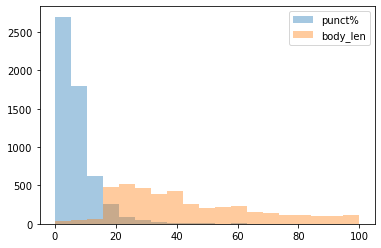

In [40]:
bins=np.linspace(0,100,20)
plt.hist(data['punct%'] ,alpha=.4,bins=bins,label='punct%')
plt.hist(data['body_len'],alpha=.4,bins=bins,label='body_len')
plt.legend()

plt.show()

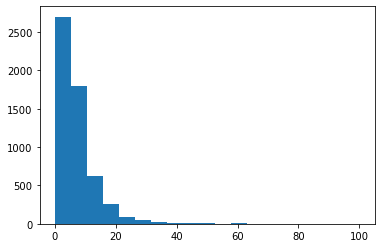

In [42]:
plt.hist(data['punct%'],bins)
plt.show()

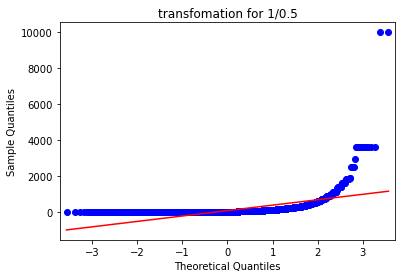

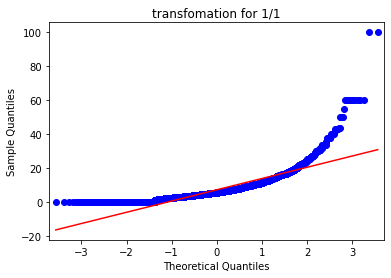

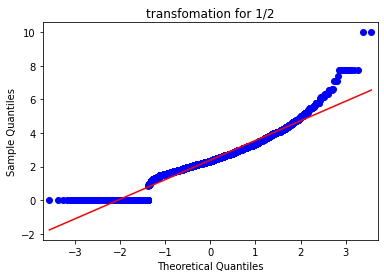

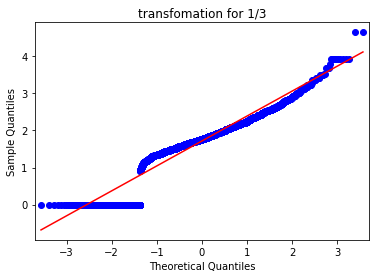

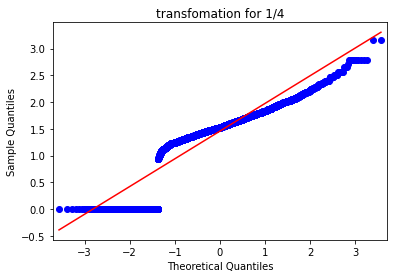

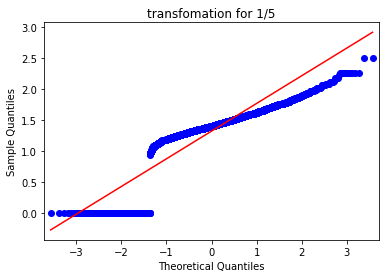

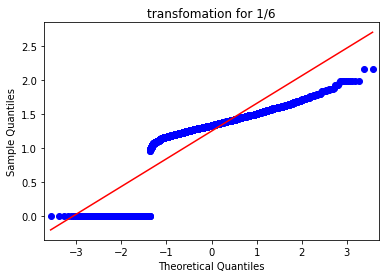

In [10]:
'''make transformation for punct%
   1-frind which trasfomtion give us pest answer'''
for i in [.5,1,2,3,4,5,6]:
    data_t = data['punct%']**(1/i)
    qqplot(data_t,line = 's')
    plt.title('transfomation for 1/{}'.format(str(i)))
    plt.show()

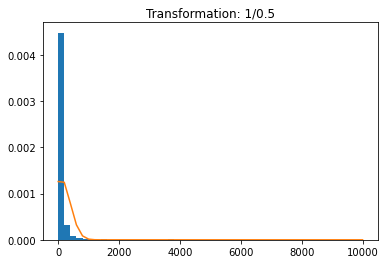

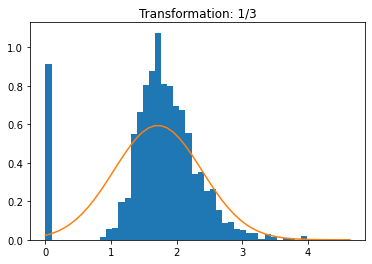

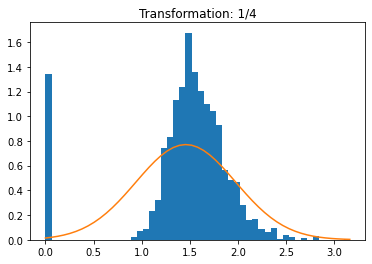

In [12]:
'''for who give best pdf(probability density function)'''
for i in [.5,3,4]:
    data_t = data['punct%']**(1/i)
    n, bins, patches = plt.hist(data_t, 50, density=True)
    mu = np.mean(data_t)
    sigma = np.std(data_t)
    plt.plot(bins, scipy.stats.norm.pdf(bins, mu, sigma))
    plt.title("Transformation: 1/{}".format(str(i)))
    plt.show()

### results for performance metrics after making modification using transformation for punnct% feature on RandomForestClassifier

In [17]:
start = time.time()
Rf_fitted = Rf.fit(feat_train_vec,y_train)
end = time.time()
fit_time = (end-start)
start = time.time()
y_pred = Rf_fitted.predict(feat_test_vec)
end = time.time()
pred_time = (end-start)
precision,recall,fscore,support = score(y_test,y_pred, pos_label='spam',average = 'binary')
print('Fit time: {} / Predict time: {} /precision: {} / recall: {} / accuracy: {}'.format(
                                        round(fit_time, 3), round(pred_time, 3),
                                        round(precision,3),round(recall,3),
                                       round((y_pred==y_test).sum()/len(y_pred),3)))

Fit time: 7.009 / Predict time: 0.203 /precision: 0.958 / recall: 0.507 / accuracy: 0.9371633752244165
